In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import lightgbm as lgb
import re


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
DATA_DIR = '/content/drive/MyDrive/00_data_1000_students'

In [ ]:
import sys
sys.path.insert(0, '../milestone-04')
from utils import load_from_csv

import timeseries_utils
import utils_lgbm

In [264]:
# Import the tables of the data set as dataframes.
# Choose random or uniform sampling
uniform = True

if not uniform:
    # DATA_DIR = '../milestone-04/data' 

    # You can use the nrows=X argument in pd.read_csv to truncate your data
    users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
    events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
    subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)
    mastery_df =  pd.read_csv('dataframe.csv', index_col=[0,1,2])
else:
    DATA_DIR = 'uniform' 
    users = pd.read_csv('{}/users_uniform_sample.csv'.format(DATA_DIR),index_col=1)
    events = pd.read_csv('{}/events_uniform_sample.csv'.format(DATA_DIR), index_col=1)
    subtasks = pd.read_csv('{}/subtasks_uniform_sample.csv'.format(DATA_DIR), index_col=1)
    mastery_df = pd.read_csv('dataframe_uniform.csv', index_col=[0,1,2])

In [265]:
index = ['event_id','user_id']
protected_features = ['country']
cat_features = ['mode_event', 'game_name','number_range', 'type_subtask'] #,'skill_id'
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
features_to_one_hot = cat_features + cat_features_withnulls
date_features = ['date','Year', 'Week', 'Day','week','year_week']
bool_feature = ['correct']

In [266]:
def create_timeseries(users, events, subtasks):
    events_and_substasks = events.reset_index().merge(subtasks.reset_index(), how='left', on=['event_id','user_id'], suffixes=('_event', '_subtask'))
    events_and_substasks['date'] = pd.to_datetime(events_and_substasks['start'])
    events_and_substasks[['Year', 'Week', 'Day']] = events_and_substasks['date'].dt.isocalendar()
    events_and_substasks['year_week'] = (events_and_substasks['Year'] - 2015) * 53 + events_and_substasks['Week']
    events_and_substasks['week'] = events_and_substasks.groupby('user_id', group_keys=False)['year_week'].apply(lambda x: x - x.iat[0]) +1
    events_and_substasks = events_and_substasks.merge(users['country'], on='user_id')
    task_events = events_and_substasks.query('type_event == "task" & correct != "nan"')
    task_events['correct'] = task_events['correct'].astype(int)
    return task_events

In [267]:
full_df = create_timeseries(users, events, subtasks)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [268]:
full_df = full_df[index + protected_features + features_to_one_hot + date_features + bool_feature]

In [269]:
# Create a feature that represents the student's overall cumulative accuracy per game
cumulative_percent_correct = full_df.groupby(['user_id','game_name'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','game_name']).rename(columns={'correct':'cumulative_percent_correct'})
full_df = full_df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

# Create a feature that represent's a games's overall cumulative correctness for all students
df_skills_mean = full_df.groupby(["game_name", "year_week"]).mean()
df_skills_mean["game_cumulative_percent_correct"] = df_skills_mean['correct'].expanding(1).mean()
df_skills_mean = df_skills_mean.reset_index()[["game_name","year_week","game_cumulative_percent_correct"]]
full_df = full_df.merge(df_skills_mean, on=["game_name","year_week"], how='left')

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [270]:
final_df = mastery_df.reset_index().copy()
final_df = final_df[final_df['mastery_level'] != 0]

In [271]:
full_df['week'] = full_df['week'].astype(int)

In [272]:
cumulative_percent_correct = full_df.groupby(['user_id','week','game_name'])['cumulative_percent_correct'].last()

In [273]:
final_df = final_df.merge(cumulative_percent_correct, on=['user_id','week','game_name'], how='left')
final_df = final_df.fillna(method='ffill')

In [274]:
final_df = final_df.merge(full_df.groupby(['user_id','week','game_name'])['game_cumulative_percent_correct'].last(), on=['user_id','week','game_name'], how='left')
final_df = final_df.fillna(method='ffill')

In [275]:
for feat in features_to_one_hot:
    one_hot_df = pd.get_dummies(full_df[feat], prefix=feat).join(full_df[['user_id','week','game_name']]).groupby(['user_id','week','game_name']).sum()
    final_df = final_df.merge(one_hot_df, on=['user_id','week','game_name'], how='left')
final_df = final_df.fillna(0)

In [276]:
final_df = final_df.merge(users['country'], on='user_id')

In [277]:
final_df = final_df.drop(columns=["mastery_level_diff"])


In [278]:
df = final_df

In [279]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

In [280]:
# LGBM only accepts int, bool and float
for col in protected_features + ["game_name"]: # "user_id"
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week'] = df['week'].astype('int32')

In [281]:
target_col = "mastery_level"
all_cols = list(df.columns)
all_cols.remove(target_col)


In [282]:
features = all_cols
target_feature = [target_col]

In [288]:
train_user_ids = []
valid_user_ids = []
test_user_ids = []
for c in users.country.unique():
    train_user_ids.extend(list(users.query(f'country == "{c}"').index[:150]))
    valid_user_ids.extend(list(users.query(f'country == "{c}"').index[150:200]))
    test_user_ids.extend(list(users.query(f'country == "{c}"').index[200:]))
    
train_df = df[df["user_id"].isin(train_user_ids)]
valid_df = df[df["user_id"].isin(valid_user_ids)]
test_df = df[df["user_id"].isin(test_user_ids)]

train = train_df[features]
y_train = train_df[target_feature]
val = valid_df[features]
y_val = valid_df[target_feature]
test = test_df[features]
y_test = test_df[target_feature]


train["user_id"] = train["user_id"].astype('category')
val["user_id"] = val["user_id"].astype('category')
test["user_id"] = test["user_id"].astype('category')


cat_features = protected_features + ["game_name", "user_id"]

lgb_train = lgb.Dataset(train, y_train, categorical_feature = cat_features, free_raw_data=False)
lgb_eval = lgb.Dataset(val, y_val, categorical_feature = cat_features, free_raw_data=False)
lgb_test = lgb.Dataset(test, y_test, categorical_feature = cat_features, free_raw_data=False, reference=lgb_train)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [246]:
# train = df.query('user_id < 600')[features]
# y_train = df.query('user_id < 600')[target_feature]

# val = df.query('600 <= user_id < 800')[features]
# y_val = df.query('600 <= user_id < 800')[target_feature]

# test = df.query('user_id >= 800')[features]
# y_test = df.query('user_id >= 800')[target_feature]

# train["user_id"] = train["user_id"].astype('category')
# val["user_id"] = val["user_id"].astype('category')
# test["user_id"] = test["user_id"].astype('category')


# cat_features = protected_features + ["game_name", "user_id"]
# lgb_train = lgb.Dataset(train, y_train, categorical_feature = cat_features, free_raw_data=False)
# lgb_eval = lgb.Dataset(val, y_val, categorical_feature = cat_features, free_raw_data=False)
# lgb_test = lgb.Dataset(test, y_test, categorical_feature = cat_features, free_raw_data=False, reference=lgb_train)

In [196]:
# cutoff = 40

In [197]:
# train = df.query(f'week < {cutoff}')[features]
# y_train = df.query(f'week < {cutoff}')[target_feature]

# val = df.query(f'{cutoff} <= week < {cutoff+10}')[features]
# y_val = df.query(f'{cutoff} <= week < {cutoff+10}')[target_feature]

# test = df.query(f'week > {cutoff}')[features]
# y_test = df.query(f'week > {cutoff}')[target_feature]

# lgb_train = lgb.Dataset(train, y_train, categorical_feature = protected_features, free_raw_data=False)
# lgb_eval = lgb.Dataset(val, y_val, categorical_feature = protected_features, free_raw_data=False)
# lgb_test = lgb.Dataset(test, y_test, categorical_feature = protected_features, free_raw_data=False, reference=lgb_train)

# # lgb_train, lgb_eval, lgb_test

In [284]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [285]:
params = {'objective': 'regression',
      'metric': ['mse','rmse','mape'],
      'seed': 0,
      'learning_rate': 0.1, #default
      "boosting_type": "gbdt" #default
      # 'num_leaves': 200,
      # 'feature_fraction': 0.75,
      # 'bagging_freq': 10,
      # 'bagging_fraction': 0.80
     }
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8,
    keep_training_booster=True,
    feval=lgbm_smape
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1769
[LightGBM] [Info] Number of data points in the train set: 96680, number of used features: 85
[LightGBM] [Info] Start training from score 0.161920
Training until validation scores don't improve for 8 rounds


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[50]	training's l2: 0.00222602	training's rmse: 0.0471807	training's mape: 0.0302197	training's SMAPE: 28.6253	valid_1's l2: 0.0141276	valid_1's rmse: 0.11886	valid_1's mape: 0.0694212	valid_1's SMAPE: 45.1317
Early stopping, best iteration is:
[62]	training's l2: 0.00199997	training's rmse: 0.0447211	training's mape: 0.0285412	training's SMAPE: 27.1734	valid_1's l2: 0.0139937	valid_1's rmse: 0.118295	valid_1's mape: 0.0690956	valid_1's SMAPE: 44.8169


In [286]:
result = model.eval(lgb_test, 'test')
print("\n".join([ f"{metric[1]}: {round(metric[2], 5)}" for metric in result]))

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


l2: 0.01379
rmse: 0.11743
mape: 0.06922


In [287]:
test = test.drop(columns=['cumulative_percent_correct', 'game_cumulative_percent_correct'])

In [202]:
last_known_cpc = train.groupby(["user_id", "game_name"])["cumulative_percent_correct"].last()
test = test.merge(last_known_cpc, how='left', on=["user_id", "game_name"])

In [203]:
last_known_gcpc = train.groupby(["game_name"])["game_cumulative_percent_correct"].last()
test = test.merge(last_known_gcpc, how='left', on=["game_name"])

In [204]:
# test['cumulative_percent_correct'] = np.NaN
# test['game_cumulative_percent_correct'] = np.NaN

In [205]:
lgb_test = lgb.Dataset(test, y_test, categorical_feature = protected_features, free_raw_data=False, reference=lgb_train)


In [289]:
result = model.eval(lgb_test, 'test')
print("\n".join([ f"{metric[1]}: {round(metric[2], 5)}" for metric in result]))

l2: 0.01833
rmse: 0.1354
mape: 0.08106


In [290]:
y_pred_test = model.predict(test, num_iteration=model.best_iteration)


In [291]:
print(f"smape: {round(smape(y_pred_test, y_test['mastery_level']), 5)}")

smape: 45.6266


In [292]:
pred_df = test.copy()
pred_df['mastery_pred'] = y_pred_test
pred_df['mastery_level'] = y_test

In [210]:
u_id = 8

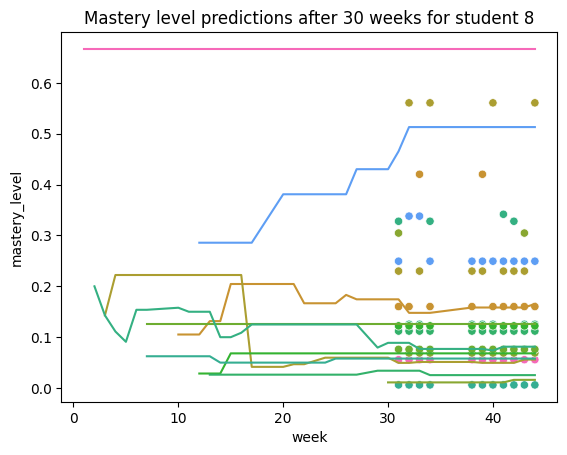

In [195]:
# sns.lineplot(
#     data=pred_df.query(f'user_id =={u_id}'),
#     x="week",
#     y="mastery_level",
#     hue='game_name',
#     legend=None
# )
sns.lineplot(
    data=df.query(f'user_id =={u_id}'),
    x="week",
    y="mastery_level",
    hue="game_name",
    legend=None
)
sns.scatterplot(
    data=pred_df.query(f'user_id =={u_id}'),
    x="week",
    y="mastery_pred",
    hue='game_name',
    legend=None
)

plt.title(f"Mastery level predictions after {cutoff} weeks for student {u_id}")
plt.savefig(f"mastery_{cutoff}_weeks_user_{u_id}.png")

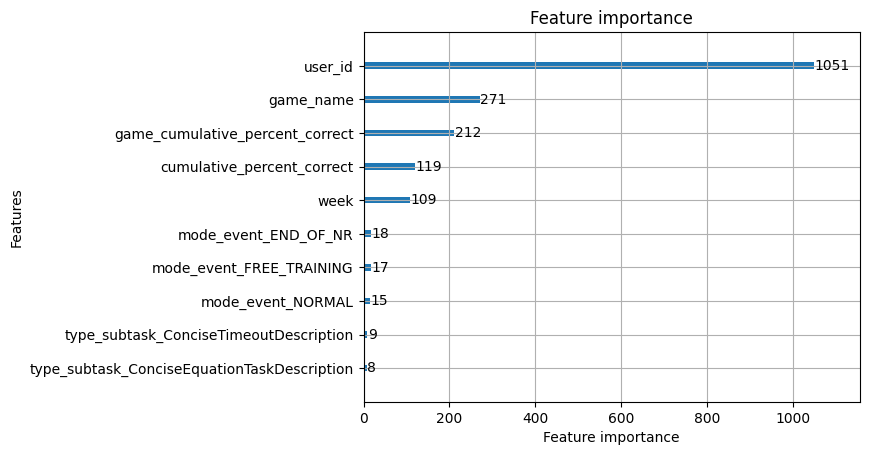

In [293]:
lgb.plot_importance(model, max_num_features=10)
plt.show()

In [212]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.1 MB/s eta 0:00:00


In [213]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


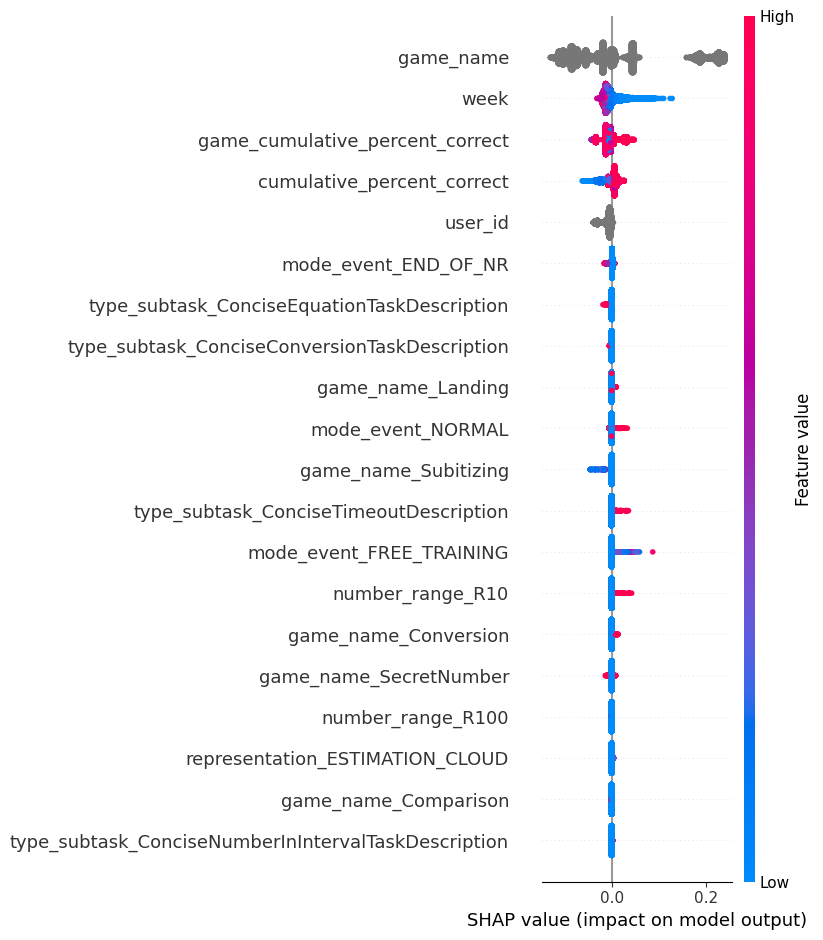

In [294]:
shap_values = shap.TreeExplainer(model).shap_values(test)
shap.summary_plot(shap_values, test)

(array([ 1368., 25213., 23525.,  8197.,  3549.,  1501.,   914.,   528.,
          506.,   257.]),
 array([-0.07012705,  0.03677468,  0.14367642,  0.25057816,  0.35747989,
         0.46438163,  0.57128337,  0.67818511,  0.78508684,  0.89198858,
         0.99889032]),
 <BarContainer object of 10 artists>)

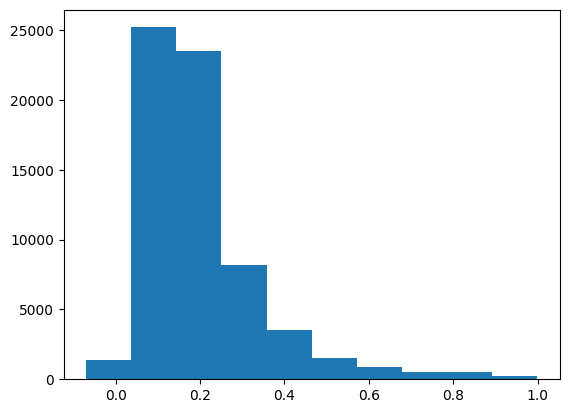

In [ ]:
pred = model.predict(test)
plt.hist(pred)

(array([3.3635e+04, 1.7076e+04, 6.7410e+03, 3.3840e+03, 2.3220e+03,
        5.2700e+02, 6.3300e+02, 2.9000e+02, 1.3000e+01, 9.3700e+02]),
 array([0.00276243, 0.10248619, 0.20220994, 0.3019337 , 0.40165746,
        0.50138122, 0.60110497, 0.70082873, 0.80055249, 0.90027624,
        1.        ]),
 <BarContainer object of 10 artists>)

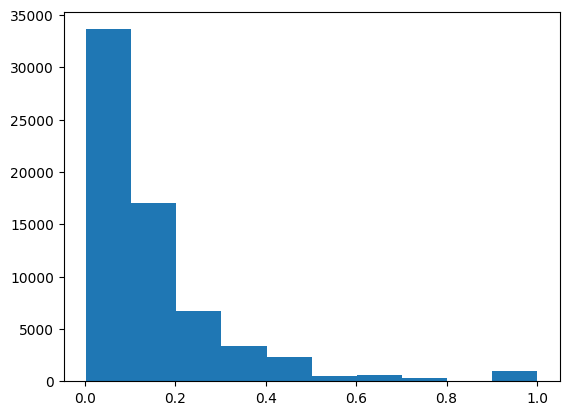

In [ ]:
plt.hist(y_test[target_feature])

In [ ]:
df.groupby("user_id")['week'].max()[df.groupby("user_id")['week'].max() > 30]

user_id
8       44
10     131
14      47
15      49
16     118
      ... 
903     68
908     46
912     43
917     33
918    113
Name: week, Length: 317, dtype: int32

# Bias

In [299]:
binary_mastered_pred = y_pred_test > 0.4
binary_mastered = y_test['mastery_level'] > 0.4

In [300]:
fairness_df = pd.DataFrame({"score": binary_mastered_pred, "label_value":binary_mastered, "country":test['country']})

In [301]:
fairness_df.to_csv("fairness_uniform_04.csv", index=False)